<a href="https://colab.research.google.com/github/garciasergio94y/RNN/blob/LSTM_onehot_samples/LSTM_onehot_samples_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalación y carga de librerías:

packages <- c("readr", "readxl", "purrr", "dplyr", "filesstrings",
              "stringr", "tidyr", "lubridate", "ggplot2",
              "tictoc", "wavelets", "reticulate", "abind",
              "tensorflow", "tfdatasets", "keras")

# Función para instalar paquetes si no están ya instalados
install_packages <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    }
}

# Aplicar la función para cada uno de los paquetes
lapply(packages, install_packages)

devtools::install_github('henry090/tfaddons')
tfaddons::install_tfaddons()

require(readr)
require(readxl)
require(purrr)
require(dplyr)
require(filesstrings)
require(stringr)
require(tidyr)
require(lubridate)
require(ggplot2)
#require(caret)
require(wavelets)
require(tictoc)
require(reticulate)
require(abind)
require(tensorflow)
require(tfaddons)
require(tfdatasets)
require(keras)


Loading required package: readr

Loading required package: readxl

Loading required package: purrr

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: filesstrings

Loading required package: stringr


Attaching package: ‘filesstrings’


The following object is masked from ‘package:dplyr’:

    all_equal


Loading required package: tidyr

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: ggplot2

Loading required package: tictoc

Loading required package: wavelets

Loading required package: reticulate

Loading required package: abind

Loading required package: tensorflow

Loading required package: tfdatasets

Loading required package: keras



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

Skipping install of 'tfaddons' from a github remote, the SHA1 (640e4c26) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: tfaddons


Attaching package: ‘tfaddons’


The following objects are masked from ‘package:keras’:

    activation_gelu, layer_multi_head_attention


The following object is masked from ‘package:readr’:

    parse_time




In [3]:
workingdir <- getwd()
datadir <- file.path(workingdir, "Datos/daily_s")
eventdir <- file.path(workingdir, "Datos/daily_s/Event")
eventdir_old <- file.path(workingdir, "Datos/daily_s/Event/old")
lotdir <- file.path(workingdir, "Datos/daily_s/Lot")
lotdir_old <- file.path(workingdir, "Datos/daily_s/Lot/old")
qcdir <- file.path(workingdir, "Datos/daily_s/qc")
qcdir_old <- file.path(workingdir, "Datos/daily_s/qc/old")
resultsdir <- file.path(workingdir, "Resultados")
figuresdir <- file.path(workingdir, "Resultados/Figuras")

In [3]:
tensorflow::tf_gpu_configured()

TensorFlow built with CUDA:  TRUE 
GPU device name:  /device:GPU:0

[1] TRUE

Lectura de archivos de datos

In [4]:
# Leer archivo dataset desde Github:
url <- "https://raw.githubusercontent.com/garciasergio94y/RNN/LSTM_onehot_samples/Resultados/data_sel_tr?token=GHSAT0AAAAAACDNEJDVVACIXFZ63YLX7FIMZD6BECQ"
data_sel_tr <- read.csv(url)

# Guardar una copia local:
# write.csv(data_sel_tr, file = "data_sel_tr", row.names = F, col.names = F) 


In [5]:
# Convertir fechas en formato POSIXct:
data_sel_tr[,1] %<>% as.POSIXct(tz = "Europe/Madrid")
head(data_sel_tr)

,TIEMPO_MUESTRA,RESULTADO,W1,W2,W3,W4,W5,W6,W7,W8,⋯,V6,V7,V8,V9,PACIENTE_SEXO,EDAD_BIN,ANALIZADOR,CODIGO_PRUEBA,NOMBRE_PRUEBA.x,CTRL
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,2022-02-28 23:20:02,4.2,0.50552333,0.5108730,1.645706,-3.1546577,0.8125566,NA,NA,NA,⋯,NA,NA,NA,NA,M,Adulto,DXI800 num 2,CLC00544,Creatina quinasa MB (masa),0
2,2022-02-28 22:02:47,9.8,-0.10191195,0.9680907,3.602823,-3.1812021,1.0638557,NA,NA,NA,⋯,NA,NA,NA,NA,F,Anciano,DXI800 num 2,CLC00544,Creatina quinasa MB (masa),0
3,2022-02-28 22:35:48,4.3,-0.14520206,-0.2750346,4.306442,-2.9114612,1.2946068,NA,NA,NA,⋯,NA,NA,NA,NA,M,Adulto,DXI800 num 2,CLC00544,Creatina quinasa MB (masa),0
4,2022-02-28 23:20:02,4.2,0.10118266,-2.6192094,4.288571,-2.3614160,1.4886256,NA,NA,NA,⋯,NA,NA,NA,NA,M,Adulto,DXI800 num 2,CLC00544,Creatina quinasa MB (masa),0
5,2022-02-28 22:02:47,9.8,0.07038626,-1.8381270,4.001825,-1.5801569,1.6319162,NA,NA,NA,⋯,NA,NA,NA,NA,F,Anciano,DXI800 num 2,CLC00544,Creatina quinasa MB (masa),0
6,2022-02-28 22:35:48,4.3,-0.36951831,1.7205326,3.532865,-0.6456295,1.7199660,NA,NA,NA,⋯,NA,NA,NA,NA,M,Adulto,DXI800 num 2,CLC00544,Creatina quinasa MB (masa),0


# Definición de funciones para transformación de variables, normalización y secuenciación de series de datos:


## Función ```normalize_train```.

Para la normalización de las variables continuas del dataset de entrenamiento y sustitución de valores NA en los coeficientes wavelet por un valor numérico arbitrario fácilmente enmascarable. Devuelve también una lista de vectores de medias y de desviaciones estándar que luego se usan como argumentos en para las funciones de normalización de los datasets de validación y test. De esta forma, el escalado y normalización se realiza con la misma media y desviación del set de entrenamiento para los otros dos datasets.

In [6]:
normalize_train <- function(data) {
   
  # Identificar las columnas que empiezan por W y la columna 'RESULTADO'
  wavelet_cols <- grep("^[WV]", colnames(data), value = TRUE)
  result_col <- "RESULTADO"
  
  # Calcular medias y desviaciones estándar por grupos de pruebas y   analizador:
  means <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
    summarise(across(c(result_col, wavelet_cols),
                     ~mean(., na.rm = T))) 
  
  std_devs <- data %>% 
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>% 
    summarise(across(c(result_col, wavelet_cols),
                     ~sd(., na.rm = T)))
  
  # Normalizar las columnas de resultado y coeficientes wavelet
  norm_data <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
    mutate(across(c(result_col, wavelet_cols), scale))%>%
    mutate(across(wavelet_cols,
                           ~ifelse(is.na(.), -99999, .))) %>%
    ungroup()
  
  # Devolver el dataframe escalado y las medias y desviaciones estándar:
  
  return(list(scaled_data = as.data.frame(norm_data), 
              means = means, stdev = std_devs))
}

## Función ```norm_test_val```.

Análoga a ```normalize_train```, pero con la diferencia de que usa la media y desviación estándar del dataset de entrenamiento para validar los datasets de validación y test:

In [7]:
norm_test_val <- function(data, means, stds) {
  
  # Identificar las columnas numéricas y seleccionarlas
  wavelet_cols <- grep("^[WV]", colnames(data), value = TRUE)
  result_col <- c("RESULTADO")
  test_cols <- "CODIGO_PRUEBA"
  cols <- c(result_col, wavelet_cols, test_cols)
  
  # Seleccionar medias y desviaciones de resultados y coeficientes   wavelet:
  means_r <- train_n$means
  stds_r <- train_n$stdev
  means_wl <- train_n$means[wavelet_cols]
  stds_wl <- train_n$stdev[wavelet_cols]
  
  # Normalizar por cada prueba las columnas de resultado y coeficientes wavelet usando las medias y desviaciones estándar de train suministradas:
  means <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
    left_join(means_r, by = c("ANALIZADOR", "CODIGO_PRUEBA"), 
              suffix = c(".val", ".means")) %>%
     ungroup()
   
  stds <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
     left_join(stds_r, by = c("ANALIZADOR", "CODIGO_PRUEBA"),
               suffix = c(".val", ".sd")) %>%
    ungroup()
     
    
  norm_data <- data %>%
    mutate(., RESULTADO.st =
             (.[,result_col]-
                select(means,
                       starts_with(result_col) &
                       ends_with(".means"))) /
                select(stds,
                       starts_with(result_col) &
                       ends_with(".sd"))
           ) %>%
    mutate(WAVELETS.st =
             across(all_of(wavelet_cols),
                    ~ (. - select(means, 
                                  starts_with(cur_column()) &
                                    ends_with(".means"))[[1]]) /
                      select(stds,
                             starts_with(cur_column()) &
                               ends_with(".sd"))[[1]])
           ) %>%
    select(-c(result_col, wavelet_cols)) %>%
    unnest(c(WAVELETS.st, RESULTADO.st)) %>%
    relocate(starts_with("RESULTADO"), .after = 1) %>%
    relocate(starts_with("W"), .after = 2) %>%
    relocate(starts_with("V"), .before = PACIENTE_SEXO) %>%
    mutate(across(wavelet_cols,
                           ~ifelse(is.na(.), -99999, .)))
    
  names(norm_data)[2]<-result_col
  
  return(as.data.frame(norm_data))
}

## Función ```code_cat_var```.

Convierte las variables categóricas tipo string en vectores numéricos y realiza una codificción one-hot, creando una lista que retiene en un vector la información de los niveles de los factores. 

In [8]:
code_cat_var <- function(data) {
  # Eliminación de la columna CODIGO_PRUEBA si solo tiene una          categoría:
  if(length(unique(data$CODIGO_PRUEBA))==1){
    data %<>% select(., -CODIGO_PRUEBA)
    }
  
  # Eliminación de los casos con sexo indeterminado, debido a que son   muy minoritarios y crean una variable innecesaria:
  
  data %<>% filter(PACIENTE_SEXO != "U")
  
  # Detección de strings:
  cat_vars <- which(sapply(data, is.character))
  # Conversión a factores:
  data_cat <- lapply(data[,cat_vars], as.factor)
  # Extracción de niveles:
  levels <- lapply(data_cat, levels)
  
  # Codificar one-hot todas las variables factor:
  encoded_cols <- lapply(seq_along(data_cat), function(i) {
    cols <- model.matrix(~ factor(data_cat[[i]]) - 1)
    colnames(cols) <- paste0(names(data)[cat_vars[i]], "_",
                             levels[[i]])
    cols
    })
  
  # Unir columnas codificadas con conjunto de datos original:
  if (!"CODIGO_PRUEBA" %in% names(data)) {
    data_encoded <- bind_cols(data %>% 
                                select(-all_of(cat_vars)),
                                encoded_cols)
    } else {
      data_encoded <-  bind_cols(data %>%
                                   select(c(-all_of(cat_vars),
                                            -"CODIGO_PRUEBA")),
                                 encoded_cols)
      }
  
    # Reordenar columnas:
  data_encoded <- data_encoded %>%
  relocate(CTRL, .after = everything())
  
  return(list(data = data_encoded, levels = levels))
}


## Función ```unique_lab_cases```.

Crea un índice de casos únicos de combinaciones de variables categóricas.

In [9]:
  unique_lab_cases <- function(df, categorical_vars) {
  unique_groups <- unique(df[categorical_vars])
  
  code <- apply(unique_groups, 1, function(row) {
    paste0(ifelse(row == 1, 1, 0), collapse = "")
  })
  unique_groups %<>% mutate(., code)
  coded_df <- df %>%
    merge(unique_groups, ., by = colnames(unique_groups)
          [-length(colnames(unique_groups))])
  coded_df <- coded_df[, c(colnames(df), "code")]
  
  return(coded_df)
}

## Función ```create_lstm_data.1```.

Diseñada para la creación de lotes de series temporales de longitud k (lookback). Basada en la función presentada en Chollet François, Deep learning with Python. Shelter Island, NY: Manning Publications Co; 2018. 335 p. Cap. 6.3.2 

In [10]:
create_lstm_data.1 <- 
  function(data, lookback, delay, min_index, max_index,
           shuffle = FALSE, batch_size, step = 1,
           predseries) {
    
  if (is.null(max_index)) max_index <- nrow(data) - delay
  i <- min_index + lookback
  gen <- function() {
    if (shuffle) {
      rows <- sample(c((min_index+lookback):max_index), 
                     size = batch_size)
    } else {
      if (i + batch_size >= max_index)
        i <<- min_index + lookback
      rows <- c(i:min(i+batch_size, max_index))
      i <<- i + length(rows)
    }
    samples <- array(0, dim = c(length(rows),
                                lookback / step,
                                dim(data)[[-1]]))
    targets <- array(0, dim = c(length(rows)))
    for (j in 1:length(rows)) {
      indices <- seq(rows[[j]] - lookback, rows[[j]],
                     length.out = dim(samples)[[2]])
      samples[j,,] <- data[indices, ]
      targets[[j]] <- data[rows[[j]] + delay, predseries]
    }
    list(samples, targets)
  }
  return(gen)
}

## Funciones ```train_gen``` y ```val_gen```.

Funciones generadoras globales de series para train y validation, Estas funciones generan de manera indefinida series con los datos de entrenamiento y validación, usando de manera consecutiva las funciones generadoras individuales almacenadas junto a los subconjuntos de datos con las posibles combinaciones de variables categóricas. Si se llega a la generación última se repite el proceso desde la primera. Incluyen un TryCatch para evitar la parada del modelo si se encuentran secuencias de datos vacías.  

In [11]:
train_gen <- function() {
  indices <- sample(length(train_k))
  
  for (i in indices) {
    sequence <- tryCatch(
      train_k[[i]](),
      error = function(e) {
        warning("Empty sequence error occurred in the generator.
                Trying the next one.")
        return(NULL)
      }
    )
    
    if (!is.null(sequence)) {
      return(sequence)
    }
  }
  
  NULL
}


val_gen <- function() {
  indices <- sample(length(val_k))
  
  for (i in indices) {
    sequence <- tryCatch(
      val_k[[i]](),
      error = function(e) {
        warning("Empty sequence error occurred in the generator.
                Trying the next one.")
        return(NULL)
      }
    )
    
    if (!is.null(sequence)) {
      return(sequence)
    }
  }
  
  NULL
}

test_gen <- function() {
  indices <- sample(length(val_k))
  
  for (i in indices) {
    sequence <- tryCatch(
      test_k[[i]](),
      error = function(e) {
        warning("Empty sequence error occurred in the generator.
                Trying the next one.")
        return(NULL)
      }
    )
    
    if (!is.null(sequence)) {
      return(sequence)
    }
  }
  
  NULL
}

# División de datasets:
Se divide el dataset en 50% de datos para entrenamiento, 25% para test y 25% para validación. Para evitar fraccionar las unidades temporales diarias usamos percentiles de la secuencia temporal en días: 

### División sin downsampling ni selección de técnicas

In [12]:

time_point_50 <- as.POSIXct(as.Date(
  quantile(data_sel_tr[,1], 0.5)))

time_point_75 <- as.POSIXct(as.Date(
  quantile(data_sel_tr[,1], 0.75)))

time_point_50
time_point_75

# Muestra de entrenamiento:
train <- data_sel_tr %>%
  subset(.[[1]] <= time_point_50)


# Muestra de validación:
val <- data_sel_tr %>%
  subset(
    .[[1]] > time_point_50 &
    .[[1]] <= time_point_75)
  

# Muestra de test:
test <- data_sel_tr %>%
  subset(.[[1]] > time_point_75)

             50% 
"2022-09-13 UTC" 

             75% 
"2022-12-21 UTC" 

### División con downsampling sin selección de técnica:

In [12]:
# Seleccionar entradas en los que no existan casos con la categoría minoritaria CTRL = 1

selected_cases_0 <- data_sel_tr %>%
  group_by(as.Date(TIEMPO_MUESTRA)) %>%
  filter(!any(CTRL == 1))

# Seleccionar el resto de entradas (sí existan casos con la categoría minoritaria CTRL = 1):
selected_cases_1 <- data_sel_tr %>%
  group_by(as.Date(TIEMPO_MUESTRA)) %>%
  filter(any(CTRL == 1))

# Downsampling seleccionando una cantidad equilibrada de muestras de la categoría mayoritaria de CTRL para cada grupo de CODIGO_PRUEBA:
downsampled_data <- selected_cases_0 %>%
  group_by(CODIGO_PRUEBA) %>%
  # Selección aleatoria del 1% de casos con CTRL = 0: 
  slice_sample(prop = 0.01, replace = FALSE) %>%
  ungroup()

data_sel_tr_ds <- bind_rows(downsampled_data, selected_cases_1)
data_sel_tr_ds %<>% arrange(TIEMPO_MUESTRA) %>%
  as.data.frame(.) %>% .[,-length(.)]

time_point_50 <- as.POSIXct(as.Date(
  quantile(data_sel_tr_ds[,1], 0.5)))

time_point_75 <- as.POSIXct(as.Date(
  quantile(data_sel_tr_ds[,1], 0.75)))

# Muestra de entrenamiento:
train <- data_sel_tr_ds %>%
  subset(.[[1]] <= time_point_50)

val <- data_sel_tr_ds %>%
  subset(.[[1]] > time_point_50 &
         .[[1]] <= time_point_75)

test <- data_sel_tr_ds %>%
  subset(.[[1]] > time_point_75)


### Exclusión del modelo general de las técnicas que no alcanzan representación de las categorías CTRL = 0/1 en todos los datasets.


In [ ]:
# Filtrado por código de pruebas que en alguno de los data set no tienen representación en la categoría CTRL = 1, y creación de una lista.
clc_sel <- list()

clc_sel[[1]] <- train_ds %>%
  group_by(CODIGO_PRUEBA) %>%
  filter(all(CTRL != 1))

clc_sel[[2]] <- val_ds %>%
  group_by(CODIGO_PRUEBA) %>%
  filter(all(CTRL != 1))

clc_sel[[3]] <- test_ds %>%
  group_by(CODIGO_PRUEBA) %>%
  filter(all(CTRL != 1))

# Unión de los elementos de la lista y extracción de los CODIGO_PRUEBA que las componen:
clc_sel %<>% do.call(rbind, .)
clc_other <- unique(clc_sel$CODIGO_PRUEBA)

# Subsetting de los dataframes de train, validation y test eliminando las entradas correspondientes a las pruebas encontradas en el paso anterior:
train %<>% subset(., !(CODIGO_PRUEBA %in% clc_other))
val %<>% subset(., !(CODIGO_PRUEBA %in% clc_other))
test %<>% subset(., !(CODIGO_PRUEBA %in% clc_other))

# Distribución tras la eliminación de estas pruebas

table(train_ds$NOMBRE_PRUEBA.x, train_ds$CTRL)
table(val_ds$NOMBRE_PRUEBA.x, val_ds$CTRL)
table(test_ds$NOMBRE_PRUEBA.x, test_ds$CTRL)

## Normalización de los datasets.

In [13]:
# Set de entrenamiento:
train_n <- train %>% normalize_train()

# Set de validación:
val_n <- val %>% norm_test_val(means = train_n$means,
                                  stds = train_n$stdev)
# Set de test:

test_n <- test %>% norm_test_val(means = train_n$means,
                                  stds = train_n$stdev)

Warning message:
“There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `across(c(result_col, wavelet_cols), ~mean(., na.rm = T))`.
Caused by warning:
! Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(result_col)

  # Now:
  data %>% select(all_of(result_col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
`summarise()` has grouped output by 'ANALIZADOR'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'ANALIZADOR'. You can override using the
`.groups` argument.


## Codificación de variables mediante one-hot.

### Sin wavelets

In [14]:
train_code <- code_cat_var(subset(train_n$scaled_data,
                                  select = -c(3:20, NOMBRE_PRUEBA.x)))

val_code <- code_cat_var(subset(val_n,
                                  select = -c(3:20, NOMBRE_PRUEBA.x)))

test_code <- code_cat_var(subset(test_n,
                                  select = -c(3:20, NOMBRE_PRUEBA.x)))


### Con wavelets

In [43]:
train_code <- code_cat_var(subset(train_n$scaled_data,
                                  select = - NOMBRE_PRUEBA.x))

val_code <- code_cat_var(subset(val_n,
                                  select = - NOMBRE_PRUEBA.x))

test_code <- code_cat_var(subset(test_n,
                                  select = - NOMBRE_PRUEBA.x))


TIEMPO_MUESTRA,RESULTADO,PACIENTE_SEXO_F,PACIENTE_SEXO_M,EDAD_BIN_Adulto,EDAD_BIN_Anciano,EDAD_BIN_Desconocido,EDAD_BIN_Joven,EDAD_BIN_Niño,ANALIZADOR_DXI800 num 1,⋯,CODIGO_PRUEBA_CLC11015,CODIGO_PRUEBA_CLC11768,CODIGO_PRUEBA_CLC11775,CODIGO_PRUEBA_CLC11797,CODIGO_PRUEBA_CLC11816,CODIGO_PRUEBA_CLC11837,CODIGO_PRUEBA_CLC11846,CODIGO_PRUEBA_CLC11854,CODIGO_PRUEBA_CLC11977,CTRL
<dttm>,"<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2022-02-28 05:00:41,-0.19572859,1,0,0,1,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
2022-02-28 05:00:41,-0.19572859,1,0,0,1,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
2022-02-28 07:27:14,-0.13213856,0,1,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
2022-02-28 07:27:14,-0.13213856,0,1,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
2022-02-28 08:13:08,-0.20355690,0,1,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
2022-02-28 08:13:08,-0.20355690,0,1,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
2022-02-28 08:13:44,-0.19753512,0,1,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
2022-02-28 08:13:44,-0.19753512,0,1,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
2022-02-28 08:35:20,-1.34587986,0,1,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0


## Preparación de series temporales de longitud k agrupadas por categorías y por fechas en los datasets de training y validación. 

In [15]:
# Creación de los códigos identificativos únicos de combinaciones de variables categóricas para el set de training usando la función unique_lab_cases e indicando las posiciones de las variables categóricas en train_code$data que se deseen incluir (en este caso el analizador): 

#categorical_vars <- c(30:56) # Todas las técnicas, con wavelets
categorical_vars <- c(12:38) # Todas las técnicas, sin wavelets
#categorical_vars <- c(12:30) # Técnicas seleccionadas, sin wavelets


train_indx <- unique_lab_cases(train_code$data,
                               categorical_vars)

# Extraemos los códigos para realizar un diccionario de traducción de códigos únicos a índices numéricos:
code_values <- unique(train_indx[,"code"])
code_dictionary <- data.frame(code = code_values)
code_dictionary %<>%  
  mutate(., index = as.numeric(factor(code_values, 
                                      levels = code_values)))

# Sustituimos los códigos de train_indx por sus índices numéricos:
train_indx$index <- code_dictionary$index[match(train_indx$code, code_dictionary$code)]
train_indx$code <- NULL
train_indx %<>% arrange(., train_indx$TIEMPO_MUESTRA)

# Creamos todas las posibles combinaciones de códigos y fechas:

train_indx$TIEMPO_MUESTRA %<>% as.Date()

combinations_train <- expand.grid(code = code_values,
                            date = unique(train_indx$TIEMPO_MUESTRA))

# Traducimos los códigos a índices:

combinations_train$index <-
  code_dictionary$index[match(combinations_train$code,
                              code_dictionary$code)]

# Creación de lista de funciones generadoras de las series temporales de longitud k por categoría de CODIGO_PRUEBA del dataset de entrenamiento. Se generan series para cada día de observación conteniendo los resultados pertenecientes a cada una de las categorías elegidas:

# Hiperparámetros para generar las series temporales:
lookback <- 20 # Longitud de la secuencia previa al target.
delay <- 0 # Se escoge 0 debido a que los targets futuros ya se                 colocaron en la misma fila que la muestra del día                  anterior.
batch_size <- 400 # Tamaño de batch.
min_index <- 1 # Indice de partida de la serie temporal.
predseries <- length(train_indx) - 2 # Posición en el dataset de la variable a predecir (CTRL) una vez eliminados TIEMPO_MUESTRA e index.

train_k <- mapply(function(index, date) {
  data <- as.matrix(
  train_indx[train_indx[,"TIEMPO_MUESTRA"] == date &
               train_indx[,"index"] == index,
             - c(1, length(train_indx))])
  max_index <- nrow(data) - delay
  
  create_lstm_data.1(
    data = data,
    lookback = lookback,
    delay = delay,
    batch_size = batch_size,
    min_index = min_index,
    max_index = max_index,
    predseries = predseries)
},
index = combinations_train$index,
date = combinations_train$date,
SIMPLIFY = T
) 


# Cálculo del número de steps de training:
train_steps <- round((nrow(train_code$data) - lookback) / batch_size)

In [16]:
# Creación de los índices identificativos de combinaciones de variables categóricas para el set de validación:
val_indx <- unique_lab_cases(val_code$data, 
                             categorical_vars)

# Usamos el diccionario de códigos creado anteriormente: 
val_indx$index <- code_dictionary$index[match(val_indx$code,
                                            code_dictionary$code)]
val_indx$code <- NULL

val_indx %<>% arrange(., val_indx$TIEMPO_MUESTRA)

# Generar todas las combinaciones de index y date para el set de validación:

val_indx$TIEMPO_MUESTRA %<>% as.Date()

combinations_val <- expand.grid(code = code_values,
                            date = unique(val_indx$TIEMPO_MUESTRA))

# Traducimos los códigos a índices:

combinations_val$index <-
  code_dictionary$index[match(combinations_val$code,
                              code_dictionary$code)]

# Creación de lista de funciones generadoras del dataset de validación:

val_k <- mapply(function(index, date) {
  data <- as.matrix(
  val_indx[val_indx[,"TIEMPO_MUESTRA"] == date &
               val_indx[,"index"] == index,
             - c(1, length(val_indx))])
  max_index <- nrow(data) - delay
  
  create_lstm_data.1(
    data = data,
    lookback = lookback,
    delay = delay,
    batch_size = batch_size,
    min_index = min_index,
    max_index = max_index,
    predseries = predseries)
  },
  index = combinations_val$index,
  date = combinations_val$date,
  SIMPLIFY = T
)  

# Cálculo del número de steps de validación:
val_steps <- round((nrow(val_code$data)-lookback) / batch_size)

In [17]:
# Mismo procedimiento que para el set de validación:

test_indx <- unique_lab_cases(test_code$data, 
                             categorical_vars)

test_indx$index <- code_dictionary$index[match(test_indx$code,
                                            code_dictionary$code)]
test_indx$code <- NULL

test_indx %<>% arrange(., test_indx$TIEMPO_MUESTRA)

test_indx$TIEMPO_MUESTRA %<>% as.Date()

combinations_test <- expand.grid(code = code_values,
                            date = unique(test_indx$TIEMPO_MUESTRA))

# Traducimos los códigos a índices:

combinations_test$index <-
  code_dictionary$index[match(combinations_test$code,
                              code_dictionary$code)]
head(test_indx)
head(combinations_test)

# Creación de lista de funciones generadoras del dataset de validación:

test_k <- mapply(function(index, date) {
  data <- as.matrix(
  test_indx[test_indx[,"TIEMPO_MUESTRA"] == date &
               test_indx[,"index"] == index,
             - c(1, length(test_indx))])
  max_index <- nrow(data) - delay
  
  create_lstm_data.1(
    data = data,
    lookback = lookback,
    delay = delay,
    batch_size = batch_size,
    min_index = min_index,
    max_index = max_index,
    predseries = predseries)
  },
  index = combinations_test$index,
  date = combinations_test$date,
  SIMPLIFY = T
)  

# Cálculo del número de steps de validación:
test_steps <- round((nrow(test_code$data)-lookback) / batch_size)

,TIEMPO_MUESTRA,RESULTADO,PACIENTE_SEXO_F,PACIENTE_SEXO_M,EDAD_BIN_Adulto,EDAD_BIN_Anciano,EDAD_BIN_Desconocido,EDAD_BIN_Joven,EDAD_BIN_Niño,ANALIZADOR_DXI800 num 1,⋯,CODIGO_PRUEBA_CLC11768,CODIGO_PRUEBA_CLC11775,CODIGO_PRUEBA_CLC11797,CODIGO_PRUEBA_CLC11816,CODIGO_PRUEBA_CLC11837,CODIGO_PRUEBA_CLC11846,CODIGO_PRUEBA_CLC11854,CODIGO_PRUEBA_CLC11977,CTRL,index
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,2022-12-21,-0.2779570,1,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,11
2,2022-12-21,-0.2621140,0,1,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,11
3,2022-12-21,1.1448604,0,1,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,11
4,2022-12-21,0.5606657,0,1,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,11
5,2022-12-21,-0.2764141,0,1,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,11
6,2022-12-21,0.9500894,0,1,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,21


,code,date,index
,<fct>,<date>,<dbl>
1,000000000000000000000000001,2022-12-21,1
2,000000000000000000000000010,2022-12-21,2
3,000000000000000000000000100,2022-12-21,3
4,000000000000000000000001000,2022-12-21,4
5,000000000000000000000010000,2022-12-21,5
6,000000000000000000000100000,2022-12-21,6


# Definición del modelo de Machine Learning. Red Neuronal Recurrente LSTM (Long-short term memory).

## Métricas


In [18]:
# Funciones para calcular precisión, recall y F1 como métricas para los modelos:
  
  K <- backend()

  precision <- function(y_true, y_pred) {
    # Verdaderos positivos: 
    true_positives <- sum(K$round(K$clip(y_true * y_pred, 0, 1)))
    
    # Posibles positivos: 
    possible_positives <- sum(K$round(K$clip(y_true, 0, 1)))
    
    # Positivos predichos:
    predicted_positives <- sum(K$round(K$clip(y_pred, 0, 1)))
    
    # Precisión: 
    precision <- true_positives / (predicted_positives + K$epsilon())
    
  return(precision)
  }
  
  recall <- function(y_true, y_pred) {
    # Verdaderos positivos: 
    true_positives <- sum(K$round(K$clip(y_true * y_pred, 0, 1)))
    
    # Posibles positivos: 
    possible_positives <- sum(K$round(K$clip(y_true, 0, 1)))
    
    # Recall:
    recall <- true_positives / (possible_positives + K$epsilon())
    
  return(recall)
}

  f1_score <- function(y_true, y_pred) {
    # Verdaderos positivos: 
    true_positives <- sum(K$round(K$clip(y_true * y_pred, 0, 1)))
    
    # Posibles positivos: 
    possible_positives <- sum(K$round(K$clip(y_true, 0, 1)))
    
    # Positivos predichos:
    predicted_positives <- sum(K$round(K$clip(y_pred, 0, 1)))
    
    # Precisión: 
    precision <- true_positives / (predicted_positives + K$epsilon())
    
    # Recall:
    recall <- true_positives / (possible_positives + K$epsilon())
    
    # F1 score:
    f1_score <- 2 * precision * recall / (precision + recall +
                                            K$epsilon())
  return(f1_score)
}

## Diseño del modelo

In [32]:
set.seed(123)
t <- train_gen()
nkp <- dim(t[[1]])

k <- nkp[2]
p <- nkp[3]

input_shape <- c(NULL, k, p)

model_1 <- keras_model_sequential() %>%
  
  #layer_masking(mask_value = -99999, input_shape = input_shape) %>%
  layer_lstm(units = 16,
             dropout = 0.5,
             recurrent_dropout = 0.2,
             return_sequences = T,
             # kernel_regularizer = regularizer_l2(l = 0.001),
             input_shape = c(NULL, k, p)) %>%
  layer_lstm(units = 16,
             dropout = 0.5,
             recurrent_dropout = 0.2,
             return_sequences = F,
             # kernel_regularizer = regularizer_l2(l = 0.001),
             input_shape = c(NULL, k, p)) %>%
  #layer_lstm(units = 32,
  #           dropout = 0.3,
  #           recurrent_dropout = 0,
  #           # kernel_regularizer = regularizer_l2(l = 0.001),
  #           return_sequences = F) %>%  
  layer_dense(units = 1, 
             # kernel_regularizer = regularizer_l2(l = 0.01),
             activation = "sigmoid")

summary(model_1)

Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”


Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_6 (LSTM)                      (None, 20, 16)                  3520        
 lstm_5 (LSTM)                      (None, 16)                      2112        
 dense_2 (Dense)                    (None, 1)                       17          
Total params: 5,649
Trainable params: 5,649
Non-trainable params: 0
________________________________________________________________________________


## Compilación y callbacks

In [33]:
model_1 %<>% compile(
  optimizer = "adam",
  #loss = "binary_crossentropy",
  loss = loss_sigmoid_focal_crossentropy(reduction = tf$keras$losses$Reduction$AUTO),
  metrics = list("binary_accuracy",
                 f1_score
                 )
  )

callbacks <- list(
  callback_model_checkpoint(file.path(resultsdir, "lstm_onehot_samples_3.keras",
                                     save_best_only = TRUE)),
  callback_reduce_lr_on_plateau(monitor = "val_loss", factor = 0.5,
                                patience = 20, min_lr = 0.00001),
  callback_early_stopping(monitor = "val_loss", patience = 50,
                          verbose = 1),
  callback_tensorboard(log_dir = resultsdir,  histogram_freq = 1,
                      write_graph = TRUE)
                          )

## Entrenamiento

In [34]:
history_1 <- model_1 %>% fit_generator(
  generator = train_gen,
  steps_per_epoch = train_steps,
  epochs = 100,
  validation_data = val_gen,
  validation_steps = val_steps,
  callbacks = callbacks
)

Se han truncado las últimas 5000 líneas del flujo de salida.
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
               

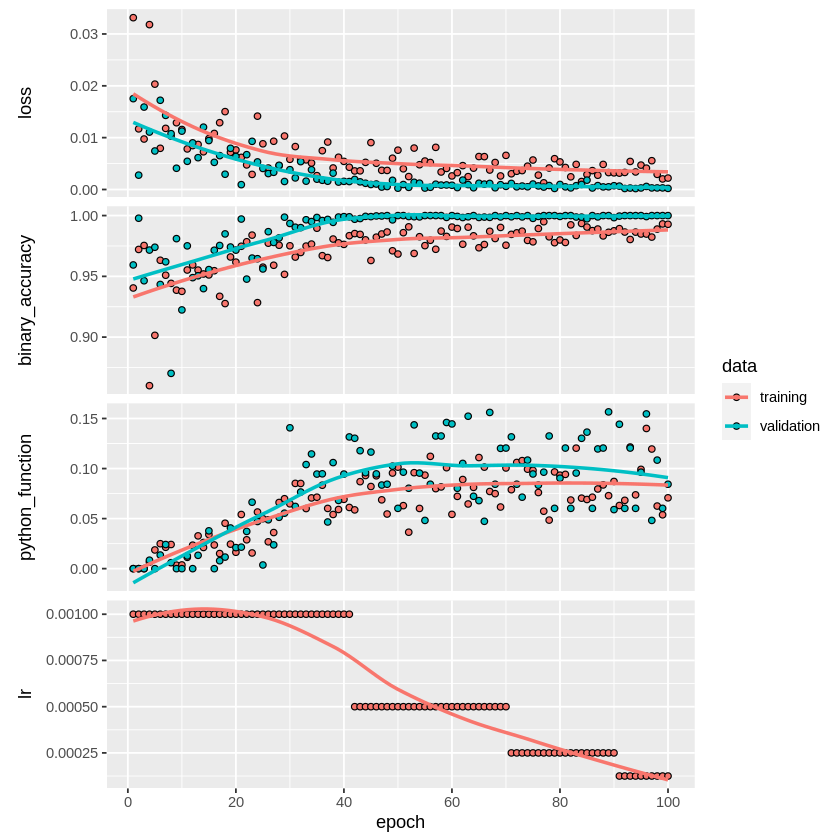

In [35]:
plot(history_1)

## Evaluación del modelo

In [36]:
set.seed(123)

# Evaluación del modelo:
path <- file.path(resultsdir, "lstm_onehot_samples_3.keras/TRUE")

model <- load_model_hdf5(path, 
                         custom_objects = list('f1_score' =
                                                 f1_score),
                         compile = F) 

model %<>% compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = list("binary_accuracy",
                 f1_score
                 )
  )

evaluation_result <- evaluate(model, test_gen, steps = test_steps)

# Obtener el nombre de las métricas
metric_names <- names(evaluation_result)

# Crear un vector para almacenar los resultados
evaluation_results <- length(metric_names)

# Almacenar los resultados en el vector
for (i in 1:length(metric_names)) {
  evaluation_results[i] <- evaluation_result[[i]]
}


Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”


## Cálculo de la línea base de sentido común:
Calcula la exactitud mínima del modelo, basada en la predicción de todos los casos con el target más frecuente

In [37]:
# Función para calcular la exactitud mínima del modelo, basada en la predicción de todos los casos con el target más frecuente

evaluate_naive_method <- function(data_df, ctrl_colname) { 
  # Cálculo de la moda de CTRL:
  ctrl_mode <- as.numeric(names(sort(table(
    data_df[[ctrl_colname]]),
    decreasing = TRUE)[1]))

  # Cálculo de accuracy:
  actual_ctrl <- data_df[[ctrl_colname]]
  predicted_ctrl <- rep(ctrl_mode, length(actual_ctrl))
  accuracy <- sum(actual_ctrl == predicted_ctrl) /
    length(actual_ctrl)

  accuracy
}

# Cálculo de accuracy basado en predecir con la moda:
accuracy_train <- evaluate_naive_method(train_n$scaled_data, "CTRL")
accuracy_val <- evaluate_naive_method(val_n, "CTRL")
accuracy_test <- evaluate_naive_method(test_n, "CTRL")

# Comparación con rendimiento obtenido:

names(evaluation_results[3]) <- "f1_score"

# Imprimir los resultados de evaluación:

sink(file.path(resultsdir, "modelgc_1_LSTM_onehot_samples.txt"))

for (i in 1:length(metric_names)) {
  metric <- metric_names[i]
  value <- evaluation_results[i]
  cat(sprintf("%s: %f\n", metric, value))
}

sprintf("Training naive accuracy: %.2f", accuracy_train)
sprintf("Validation naive accuracy: %.2f", accuracy_val)
sprintf("Test naive accuracy: %.2f", accuracy_val)

# Cerrar el archivo de salida
sink()

loss: 0.044080
binary_accuracy: 1.000000
python_function: 0.149425


[1] "Training naive accuracy: 0.94"

[1] "Validation naive accuracy: 0.93"

[1] "Test naive accuracy: 0.93"

## Evaluación por técnica

In [39]:
# Función para seleccionar los índices en test_indx que corresponden a una combinación determinada de CODIGO_PRUEBA, Y ANALIZADOR. Usa el argumento n según la estructura de datos en función de si hay wavelets o no:

n <- 11 # Sin wavelets ni analizador

index_select <- function(n) {
  
  # Opciones para elegir CLC y ANALIZADOR:
  clc_opt <- test_code$levels$CODIGO_PRUEBA
  #anal_opt <- test_code$levels$ANALIZADOR
  
  # Introducción de la fecha por el usuario:
  #date <- readline(
   # "fecha del día anterior a la predicción (aaaa-mm-dd): ")
  #if(!date %in% as.Date(test_code$data$TIEMPO_QC))
   #  print("fecha no incluida en dataset")
  
  # Introducción de prueba, nivel y analizador:
  clc <- clc_opt[menu(clc_opt, 
                      title = "Código CLC de prueba: ",
                      graphics = F)]
  #anal <- anal_opt[menu(anal_opt, 
  #                      title = "Analizador: ",
  #                      graphics = T)]
    
  cat("Indice correspondiente a la prueba: ", clc, "\n", 
  "analizador: ")#, anal, "\n")
  
  # Conversión de las variables introducidas en índice:
  
  col_clc <- which(grepl(clc, names(test_indx)))-n
  #col_anal <- which(grepl(anal, names(test_indx)))-n
  pos <- list(col_clc)#, col_anal)
  
  code <- rep(0, length(categorical_vars+2))
  
  for (i in seq_along(pos)) {
    code[pos[[i]]] <- 1 
  }
  code <- paste0(as.character(code), collapse = "")
  
  index <- code_dictionary$index[match(code,
                                       code_dictionary$code)]
  print(index)
  return(index)
  
}

index_pred <- index_select(n)

  test_pred <- lapply(index_pred, function(idx) {
    create_lstm_data.2(
      data = as.matrix(test_indx[test_indx[,"index"] == idx,
                                 -c(1, length(test_indx))]),
      lookback = lookback,
      delay = delay,
      batch_size = batch_size,
      min_index = min_index,
      max_index = 
      nrow(as.matrix(test_indx[test_indx[,"index"] == idx,]))-delay-1,
      predseries = predseries)
  }
  )


ERROR: ignored

In [ ]:
# Obtener las series y sus predicciones utilizando la función generadora de tests por categorías y obtener la predicción del modelo:
x <- test_pred[[1]]()[[1]]
y_pred <- predict(model, x, probability = T)
y_true <- test_pred[[1]]()[[2]]

preds <- prediction(as.vector(y_pred), as.vector(y_true))
perf <- performance(preds, "tpr","fpr")

roc(as.vector(y_true), as.vector(y_pred), plot = TRUE, 
    legacy.axes = TRUE,
    percent = TRUE, xlab = "Porcentaje Falsos positivos",
    ylab = "Porcentaje verdaderos postivios", col = "#377eb8", lwd = 2,
    print.auc = TRUE)